In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "/tmp/chapter11/"
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Vanishing/Exploding Gradients Problem

In [0]:
def logit(z):
  return 1/(1+np.exp(-z))

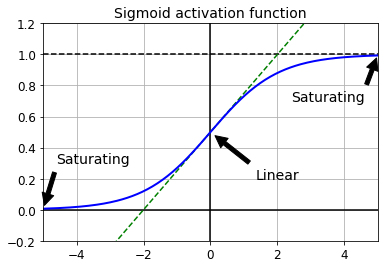

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("sigmoid_saturation_plot")
plt.show()

Xavier and He Initialization
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:

several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.
it does not support tensorflow.contrib.framework.arg_scope() (introduced later in chapter 11).
it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [0]:
reset_graph()

n_inputs = 28*28 # mnist
n_hidden1=300

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init,
                          name="hidden1")

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Nonsaturating Activation Functions

Leaky ReLU

In [0]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha*z, z)

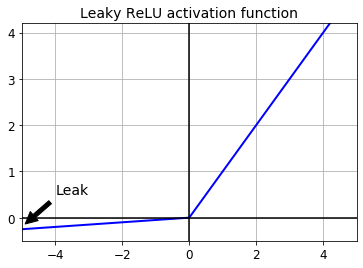

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

# save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")

In [0]:
def leaky_relu(z, name=None):
  return tf.maximum(0.01*z, z ,name=name)

hidden1=tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [0]:
reset_graph()

n_inputs=28*28
n_hidden1=300
n_hidden2=100
n_outputs=10

In [0]:
X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
  hidden1=tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
  hidden2=tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
  logits=tf.layers.dense(hidden2, n_outputs,name="outputs")

In [0]:
with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss=tf.reduce_mean(xentropy,name="loss")

In [15]:
learning_rate=0.01
with tf.name_scope("loss"):
  optimizer=tf.train.GradientDescentOptimizer(learning_rate)
  training_op=optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
with tf.name_scope("eval"):
  correct=tf.nn.in_top_k(logits,y,1)
  accuracy=tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
init = tf.global_variables_initializer()
saver=tf.train.Saver()

Let's load the data:

Warning: tf.examples.tutorials.mnist is deprecated. We will use tf.keras.datasets.mnist instead.

In [18]:
(X_train, y_train), (X_test, y_test)=tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28*28)/255.0
X_test = X_test.astype(np.float32).reshape(-1,28*28)/255.0
y_train=y_train.astype(np.int32)
y_test=y_test.astype(np.int32)
X_valid, X_train=X_train[:5000],X_train[5000:]
y_valid, y_train=y_train[:5000],y_train[5000:]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def shuffle_batch(X,y,batch_size):
  rnd_idx = np.random.permutation(len(X))
  n_batches = len(X)//batch_size
  for batch_idx in np.array_split(rnd_idx, n_batches):
    X_batch, y_batch = X[batch_idx], y[batch_idx]
    yield X_batch, y_batch

In [20]:
n_epochs=40
batch_size=50

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    if epoch%5==0:
      acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
      acc_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
      print("epoch:",epoch, "batch accuracy:",acc_batch*100, "val accuracy:",
            acc_val*100)
      save_path=saver.save(sess, "./my_model_final.ckpt")

epoch: 0 batch accuracy: 86.00000143051147 val accuracy: 90.39999842643738
epoch: 5 batch accuracy: 93.99999976158142 val accuracy: 94.95999813079834
epoch: 10 batch accuracy: 92.00000166893005 val accuracy: 96.52000069618225
epoch: 15 batch accuracy: 93.99999976158142 val accuracy: 97.06000089645386
epoch: 20 batch accuracy: 100.0 val accuracy: 97.61999845504761
epoch: 25 batch accuracy: 100.0 val accuracy: 97.75999784469604
epoch: 30 batch accuracy: 98.00000190734863 val accuracy: 97.82000184059143
epoch: 35 batch accuracy: 100.0 val accuracy: 97.8600025177002


ELU

In [0]:
def elu(z, alpha=1):
  return np.where(z<0,alpha*(np.exp(z)-1),z)

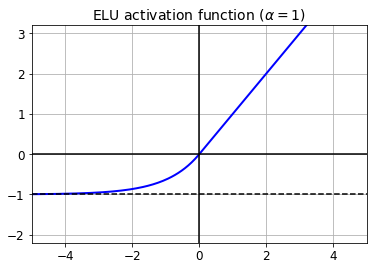

In [22]:

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer

In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None,n_inputs),name="X")

In [0]:
hidden1=tf.layers.dense(X,n_hidden1, activation=tf.nn.elu,name="hidden1")

SELU
This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [0]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [0]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
  return scale*elu(z,alpha)

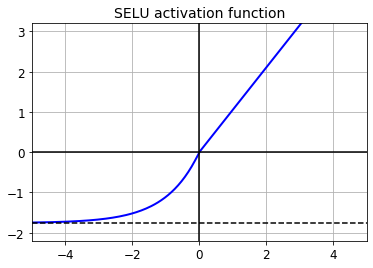

In [27]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


The tf.nn.selu() function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:



In [0]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in tf.contrib.nn.alpha_dropout() since TF 1.4 (or check out this implementation by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [0]:
reset_graph()

n_inputs=28*28 #mnist
n_hidden1=300
n_hidden2=100
n_outputs=10

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.int32, shape=(None),name="y")

with tf.name_scope("dnn"):
  hidden1=tf.layers.dense(X,n_hidden1, activation=selu, name="hidden1")
  hidden2=tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
  logits=tf.layers.dense(hidden2, n_outputs,name="outputs")

with tf.name_scope("loss"):
  xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss=tf.reduce_mean(xentropy,name="loss")

learning_rate=0.01
with tf.name_scope("train"):
  optimizer= tf.train.GradientDescentOptimizer(learning_rate)
  training_op=optimizer.minimize(loss)

with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits,y,1)
  accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))

init = tf.global_variables_initializer()
saver=tf.train.Saver()

n_epochs=40
batch_size=50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:



In [31]:
means=X_train.mean(axis=0, keepdims=True)
stds=X_train.std(axis=0, keepdims=True)+1e-10
X_val_scaled=(X_valid-means)/stds

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train,y_train, batch_size):
      X_batch_scaled=(X_batch -means)/stds
      sess.run(training_op, feed_dict={X:X_batch_scaled, y:y_batch})
    if epoch%5==0:
      acc_batch=accuracy.eval(feed_dict={X:X_batch_scaled, y:y_batch})
      acc_valid=accuracy.eval(feed_dict={X:X_val_scaled, y:y_valid})
      print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
  save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.94 Validation accuracy: 0.9388
5 Batch accuracy: 0.98 Validation accuracy: 0.9634
10 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 1.0 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.969
25 Batch accuracy: 1.0 Validation accuracy: 0.9692
30 Batch accuracy: 1.0 Validation accuracy: 0.9706
35 Batch accuracy: 1.0 Validation accuracy: 0.9706


Batch Normalization

Note: the book uses tensorflow.contrib.layers.batch_norm() rather than tf.layers.batch_normalization() (which did not exist when this chapter was written). It is now preferable to use tf.layers.batch_normalization(), because anything in the contrib module may change or be deleted without notice. Instead of using the batch_norm() function as a regularizer parameter to the fully_connected() function, we now use batch_normalization() and we explicitly create a distinct layer. The parameters are a bit different, in particular:

decay is renamed to momentum,
is_training is renamed to training,
updates_collections is removed: the update operations needed by batch normalization are added to the UPDATE_OPS collection and you need to explicity run these operations during training (see the execution phase below),
we don't need to specify scale=True, as that is the default.
Also note that in order to run batch norm just before each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the tf.layers.dense() function is incompatible with tf.contrib.layers.arg_scope() (which is used in the book), we now use python's functools.partial() function instead. It makes it easy to create a my_dense_layer() function that just calls tf.layers.dense() with the desired parameters automatically set (unless they are overridden when calling my_dense_layer()). As you can see, the code remains very similar.

In [32]:
reset_graph()

import tensorflow as tf

n_inputs=28*28
n_hidden1=300
n_hidden2=100
n_outputs=10

X=tf.placeholder(tf.float32, shape=(None,n_inputs),name="X")

training = tf.placeholder_with_default(False, shape=(), name="training")

hidden1=tf.layers.dense(X, n_hidden1, name="hidden1")
bn1=tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act=tf.nn.elu(bn1)

hidden2=tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2=tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn=tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits=tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name="training")

To avoid repeating the same parameters over and over again, we can use Python's partial() function:

In [0]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training,
                              momentum=0.9)
hidden1=tf.layers.dense(X, n_hidden1, name="hidden1")
bn1=my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2=my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn=tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits=my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [0]:
reset_graph()

batch_norm_momentum = 0.9

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

with tf.name_scope("dnn"):
  he_init = tf.variance_scaling_initializer()

  my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, 
                                momentum=batch_norm_momentum)
  my_dense_layer = partial(tf.layers.dense,
                           kernel_initializer = he_init)
  
  hidden1=my_dense_layer(X, n_hidden1, name="hidden1")
  bn1=tf.nn.elu(my_batch_norm_layer(hidden1))
  hidden2=my_dense_layer(bn1, n_hidden2, name="hidden2")
  bn2=tf.nn.elu(my_batch_norm_layer(hidden2))
  logits_before_bn=my_dense_layer(bn2, n_outputs, name="output")
  logits=my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss= tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("train"):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op =optimizer.minimize(loss)

with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits,y,1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


init = tf.global_variables_initializer()
saver= tf.train.Saver()

In [0]:
n_epochs = 20
batch_size=200

In [37]:
extra_update_op = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run([training_op, extra_update_op], 
               feed_dict = {training:True, X:X_batch, y:y_batch})
    accuracy_val = sess.run(accuracy, feed_dict={training:False, X:X_valid,
                                                  y:y_valid})
    print("Epoch:",epoch, "Val accuracy:",accuracy_val)
  saver_path=saver.save(sess, "./my_final_model.ckpt")

Epoch: 0 Val accuracy: 0.8952
Epoch: 1 Val accuracy: 0.9202
Epoch: 2 Val accuracy: 0.9318
Epoch: 3 Val accuracy: 0.9422
Epoch: 4 Val accuracy: 0.9468
Epoch: 5 Val accuracy: 0.954
Epoch: 6 Val accuracy: 0.9568
Epoch: 7 Val accuracy: 0.96
Epoch: 8 Val accuracy: 0.962
Epoch: 9 Val accuracy: 0.9638
Epoch: 10 Val accuracy: 0.9662
Epoch: 11 Val accuracy: 0.9682
Epoch: 12 Val accuracy: 0.9672
Epoch: 13 Val accuracy: 0.9696
Epoch: 14 Val accuracy: 0.9706
Epoch: 15 Val accuracy: 0.9704
Epoch: 16 Val accuracy: 0.9718
Epoch: 17 Val accuracy: 0.9726
Epoch: 18 Val accuracy: 0.9738
Epoch: 19 Val accuracy: 0.9742


In [38]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'output/kernel:0',
 'output/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [39]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'output/kernel:0',
 'output/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")


In [0]:
learning_rate=0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:

In [0]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
init = tf.global_variables_initializer()
saver=tf.train.Saver()

In [0]:
n_epochs = 20
batch_size=200

In [46]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7942
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.9216
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.957
15 Validation accuracy: 0.9564
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9612


Reusing Pretrained Layers

Reusing a TensorFlow Model

First you need to load the graph's structure. The import_meta_graph() function does just that, loading the graph's operations into the default graph, and returning a Saver that you can then use to restore the model's state. Note that by default, a Saver saves the structure of the graph into a .meta file, so that's the file you should load:

In [0]:
reset_graph()

In [0]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [49]:
for op in tf.get_default_graph().get_operations():
  print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Once you know which operations you need, you can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods:

In [0]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [0]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [0]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9638
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9704
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.9714


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of import_meta_graph():

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

And continue training:

In [55]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9638
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9704
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.9714


In general you will want to reuse only the lower layers. If you are using import_meta_graph() it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [0]:
reset_graph()

n_hidden4=20
n_outputs=10

saver=tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X=tf.get_default_graph().get_tensor_by_name("X:0")
y=tf.get_default_graph().get_tensor_by_name("y:0")

hidden3=tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4=tf.layers.dense(hidden3,n_hidden4,activation=tf.nn.relu,name="activation")
new_logits=tf.layers.dense(new_hidden4,n_outputs,name="new_outputs")

with tf.name_scope("loss"):
  xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=new_logits)
  loss=tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("new_eval"):
  correct=tf.nn.in_top_k(new_logits,y,1)
  accuracy=tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")

with tf.name_scope("new_train"):
  optimizer=tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

init=tf.global_variables_initializer()
new_saver=tf.train.Saver()

And we can train this new model:



In [57]:
with tf.Session() as sess:
  init.run()
  saver.restore(sess,"./my_model_final.ckpt")

  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train,y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    accuracy_val = sess.run(accuracy, feed_dict={X:X_valid, y:y_valid})
    print("epoch:",epoch, "Val accuracy",accuracy_val)

  save_path=new_saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
epoch: 0 Val accuracy 0.919
epoch: 1 Val accuracy 0.9394
epoch: 2 Val accuracy 0.949
epoch: 3 Val accuracy 0.9524
epoch: 4 Val accuracy 0.9552
epoch: 5 Val accuracy 0.956
epoch: 6 Val accuracy 0.9578
epoch: 7 Val accuracy 0.961
epoch: 8 Val accuracy 0.9614
epoch: 9 Val accuracy 0.964
epoch: 10 Val accuracy 0.965
epoch: 11 Val accuracy 0.9656
epoch: 12 Val accuracy 0.964
epoch: 13 Val accuracy 0.967
epoch: 14 Val accuracy 0.9678
epoch: 15 Val accuracy 0.9678
epoch: 16 Val accuracy 0.9696
epoch: 17 Val accuracy 0.9674
epoch: 18 Val accuracy 0.9696
epoch: 19 Val accuracy 0.9706


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one Saver to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another Saver to save the new model, once it is trained:

In [59]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9026
1 Validation accuracy: 0.9332
2 Validation accuracy: 0.9428
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9524
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.9588
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9606
10 Validation accuracy: 0.962
11 Validation accuracy: 0.962
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.9658
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.966
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9676


Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a feed_dict:

In [0]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [61]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [62]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using get_collection() and specifying the scope:

In [63]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Freezing the Lower Layers

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [66]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8966
1 Validation accuracy: 0.93
2 Validation accuracy: 0.9404
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.948
5 Validation accuracy: 0.951
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9532
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9566
10 Validation accuracy: 0.956
11 Validation accuracy: 0.9568
12 Validation accuracy: 0.9568
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9586
15 Validation accuracy: 0.9578
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9604


In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [70]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9022
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.943
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.9572
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9582


Caching the Frozen Layers

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [0]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9022
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.943
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.9572
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9582


Faster Optimizers

Momentum optimization

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

Nesterov Accelerated Gradient

In [0]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

AdaGrad

In [0]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

RMSProp

In [0]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

Adam Optimization

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

Learning Rate Scheduling

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [0]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [82]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9672
1 Validation accuracy: 0.9738
2 Validation accuracy: 0.9756
3 Validation accuracy: 0.9816
4 Validation accuracy: 0.9828


Avoiding Overfitting Through Regularization

L1 and L2  regularization

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [0]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the tf.layers.dense() function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's partial() function to avoid repeating the same arguments over and over again. Note that we set the kernel_regularizer argument:

In [0]:
scale = 0.001

In [89]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Next we must add the regularization losses to the base loss:

In [0]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [0]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [92]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9124
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9218
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


Dropout

Note: the book uses tf.contrib.layers.dropout() rather than tf.layers.dropout() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dropout(), because anything in the contrib module may change or be deleted without notice. The tf.layers.dropout() function is almost identical to the tf.contrib.layers.dropout() function, except for a few minor differences. Most importantly:

you must specify the dropout rate (rate) rather than the keep probability (keep_prob), where rate is simply equal to 1 - keep_prob,
the is_training parameter is renamed to training.

In [0]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [94]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

Instructions for updating:
Use keras.layers.dropout instead.


In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [96]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9246
1 Validation accuracy: 0.9468
2 Validation accuracy: 0.9492
3 Validation accuracy: 0.9508
4 Validation accuracy: 0.9628
5 Validation accuracy: 0.9632
6 Validation accuracy: 0.9618
7 Validation accuracy: 0.9664
8 Validation accuracy: 0.967
9 Validation accuracy: 0.967
10 Validation accuracy: 0.9684
11 Validation accuracy: 0.9686
12 Validation accuracy: 0.9688
13 Validation accuracy: 0.97
14 Validation accuracy: 0.972
15 Validation accuracy: 0.9712
16 Validation accuracy: 0.9728
17 Validation accuracy: 0.9734
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9732


Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the clip_by_norm() function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [0]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [0]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the training_op, we run the clip_weights and clip_weights2 operations:

In [0]:
n_epochs = 20
batch_size = 50

In [102]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9568
1 Validation accuracy: 0.9696
2 Validation accuracy: 0.971
3 Validation accuracy: 0.9776
4 Validation accuracy: 0.977
5 Validation accuracy: 0.9782
6 Validation accuracy: 0.982
7 Validation accuracy: 0.982
8 Validation accuracy: 0.9794
9 Validation accuracy: 0.9818
10 Validation accuracy: 0.9826
11 Validation accuracy: 0.9846
12 Validation accuracy: 0.9818
13 Validation accuracy: 0.9836
14 Validation accuracy: 0.9844
15 Validation accuracy: 0.9842
16 Validation accuracy: 0.984
17 Validation accuracy: 0.9842
18 Validation accuracy: 0.9842
19 Validation accuracy: 0.9846


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a max_norm_regularizer() function:

In [0]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the kernel_regularizer argument:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [0]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [0]:
n_epochs = 20
batch_size = 50

In [108]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.97
2 Validation accuracy: 0.9732
3 Validation accuracy: 0.9748
4 Validation accuracy: 0.9754
5 Validation accuracy: 0.979
6 Validation accuracy: 0.981
7 Validation accuracy: 0.9812
8 Validation accuracy: 0.9814
9 Validation accuracy: 0.9806
10 Validation accuracy: 0.9822
11 Validation accuracy: 0.9816
12 Validation accuracy: 0.9812
13 Validation accuracy: 0.9822
14 Validation accuracy: 0.9826
15 Validation accuracy: 0.9824
16 Validation accuracy: 0.982
17 Validation accuracy: 0.9824
18 Validation accuracy: 0.9826
19 Validation accuracy: 0.9824



Exercise solutions

Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function.

In [0]:
he_init= tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.relu, initializer=he_init):
  with tf.variable_scope(name,"dnn"):
    for layer in range(n_hidden_layers):
      inputs = tf.layers.dense(inputs, n_neurons,activation=activation,
                               kernel_initializer=initializer, 
                               name="hidden%d"%(layer+1))
    return inputs

In [0]:
input = 28*28
n_outputs=5

reset_graph()

X=tf.placeholder(tf.float32, shape=(None,n_inputs),name="X")
y=tf.placeholder(tf.int32,shape=(None),name="y")

dnn_outputs=dnn(X)

logits=tf.layers.dense(dnn_outputs,n_outputs,kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits,name="Y_proba")

Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [0]:
learning_rate = 0.01

xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss=tf.reduce_mean(xentropy, name="loss")

optimizer=tf.train.AdamOptimizer(learning_rate)
training_op=optimizer.minimize(loss,name="training_op")

correct=tf.nn.in_top_k(logits,y,1)
accuracy=tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")

init=tf.global_variables_initializer()
saver=tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [0]:
X_train1=X_train[y_train<5]
y_train1=y_train[y_train<5]
X_valid1=X_valid[y_valid<5]
y_valid1=y_valid[y_valid<5]
X_test1=X_test[y_test<5]
y_test1=y_test[y_test<5]

In [113]:
n_epochs=1000
batch_size=20

max_checks_without_progress=20
checks_without_progress=0
best_loss=np.infty

with tf.Session() as sess:
  init.run()

  for epoch in range(n_epochs):
    rnd_idx=np.random.permutation(len(X_train1))
    for rnd_indices in np.array_split(rnd_idx, len(X_train1)//batch_size):
      X_batch, y_batch=X_train1[rnd_indices], y_train1[rnd_indices]
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    loss_val, acc_val= sess.run([loss,accuracy], feed_dict={X:X_valid1, y:y_valid1})
    if loss_val<best_loss:
      save_path = saver.save(sess,"./my_mnist_model_0_to_4.ckpt")
      best_loss = loss_val
      checks_without_progress=0
    else:
      checks_without_progress +=1
      if checks_without_progress>max_checks_without_progress:
        print("Early stopping")
        break
    print("Validation_loss",loss_val,"Best_loss",best_loss,"Epoch",epoch,"Accuracy",acc_val*100)

with tf.Session() as sess:
  saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
  acc_test=accuracy.eval(feed_dict={X:X_test1,y:y_test1})
  print("Final accuracy",acc_test*100)

Validation_loss 0.11710338 Best_loss 0.11710338 Epoch 0 Accuracy 96.48162722587585
Validation_loss 0.13373975 Best_loss 0.11710338 Epoch 1 Accuracy 96.83346152305603
Validation_loss 0.09221167 Best_loss 0.09221167 Epoch 2 Accuracy 97.38076329231262
Validation_loss 0.1037679 Best_loss 0.09221167 Epoch 3 Accuracy 98.16262722015381
Validation_loss 0.4248339 Best_loss 0.09221167 Epoch 4 Accuracy 97.45895266532898
Validation_loss 0.14545596 Best_loss 0.09221167 Epoch 5 Accuracy 97.49804735183716
Validation_loss 0.32450268 Best_loss 0.09221167 Epoch 6 Accuracy 89.01485800743103
Validation_loss 0.10469381 Best_loss 0.09221167 Epoch 7 Accuracy 97.61532545089722
Validation_loss 0.25599167 Best_loss 0.09221167 Epoch 8 Accuracy 94.99608874320984
Validation_loss 0.13773921 Best_loss 0.09221167 Epoch 9 Accuracy 97.02892899513245
Validation_loss 0.12192052 Best_loss 0.09221167 Epoch 10 Accuracy 97.38076329231262
Validation_loss 0.59023184 Best_loss 0.09221167 Epoch 11 Accuracy 96.83346152305603
Vali

Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve.

Let's create a DNNClassifier class, compatible with Scikit-Learn's RandomizedSearchCV class, to perform hyperparameter tuning. Here are the key points of this implementation:

the __init__() method (constructor) does nothing more than create instance variables for each of the hyperparameters.




the fit() method creates the graph, starts a session and trains the model:

it calls the _build_graph() method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.

the _dnn() method builds the hidden layers, just like the dnn() function above, but also with support for batch normalization and dropout (for the next exercises).

if the fit() method is given a validation set (X_valid and y_valid), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the _get_model_params() method to get all the graph's variables and their values, and the _restore_model_params() method to restore the variable values (of the best model found). This trick helps speed up training.

After the fit() method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the close_session() method.




the predict_proba() method uses the trained model to predict the class probabilities.

the predict() method calls predict_proba() and returns the class with the highest probability, for each instance.

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)      

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):



In [115]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.123503	Best loss: 0.123503	Accuracy: 97.26%
1	Validation loss: 1.161265	Best loss: 0.123503	Accuracy: 39.91%
2	Validation loss: 1.182354	Best loss: 0.123503	Accuracy: 42.34%
3	Validation loss: 0.890813	Best loss: 0.123503	Accuracy: 60.56%
4	Validation loss: 0.621042	Best loss: 0.123503	Accuracy: 74.71%
5	Validation loss: 0.375756	Best loss: 0.123503	Accuracy: 79.59%
6	Validation loss: 0.391356	Best loss: 0.123503	Accuracy: 79.20%
7	Validation loss: 0.414316	Best loss: 0.123503	Accuracy: 93.08%
8	Validation loss: 0.249316	Best loss: 0.123503	Accuracy: 95.47%
9	Validation loss: 0.196112	Best loss: 0.123503	Accuracy: 96.40%
10	Validation loss: 0.358238	Best loss: 0.123503	Accuracy: 91.56%
11	Validation loss: 0.236934	Best loss: 0.123503	Accuracy: 96.52%
12	Validation loss: 0.274675	Best loss: 0.123503	Accuracy: 94.64%
13	Validation loss: 0.295208	Best loss: 0.123503	Accuracy: 94.61%
14	Validation loss: 0.213756	Best loss: 0.123503	Accuracy: 96.01%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f7dafee28c8>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

The model is trained, let's see if it gets the same accuracy as earlier:

In [116]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9768437439190504

Yep! Working fine. Now we can use Scikit-Learn's RandomizedSearchCV class to search for better hyperparameters (this may take over an hour, depending on your system):

In [117]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7f7dafee28c8> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.127758	Best loss: 0.127758	Accuracy: 96.48%
1	Validation loss: 0.150425	Best loss: 0.127758	Accuracy: 96.68%
2	Validation loss: 0.135460	Best loss: 0.127758	Accuracy: 96.60%
3	Validation loss: 0.135611	Best loss: 0.127758	Accuracy: 96.36%
4	Validation loss: 1.430947	Best loss: 0.127758	Accuracy: 34.68%
5	Validation loss: 0.812618	Best loss: 0.127758	Accuracy: 58.05%
6	Validation loss: 0.736221	Best loss: 0.127758	Accuracy: 59.93%
7	Validation loss: 0.770189	Best loss: 0.127758	Accuracy: 58.60%
8	Validation loss: 0.707574	Best loss: 0.127758	Accuracy: 58.76%
9	Validation loss: 0.737203	Best loss: 0.127758	Accuracy: 59.03%
10	Validation loss: 0.735912	Best loss: 0.127758	Accuracy: 59.34%
11	Validation loss: 0.729882	Best loss: 0.127758	Accuracy: 60.83%
12	Validation loss: 0.798347	Best loss: 0.127758	Accuracy: 60.91%
13	Validation loss: 1.018460	Best loss: 0.127758	Accuracy: 57.82%
14	Validation loss: 0.759845	Best loss: 0.127758	Accuracy: 57.74%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


0	Validation loss: 0.135115	Best loss: 0.135115	Accuracy: 96.60%
1	Validation loss: 0.117237	Best loss: 0.117237	Accuracy: 97.19%
2	Validation loss: 0.159745	Best loss: 0.117237	Accuracy: 96.40%
3	Validation loss: 0.107378	Best loss: 0.107378	Accuracy: 97.19%
4	Validation loss: 0.103353	Best loss: 0.103353	Accuracy: 97.03%
5	Validation loss: 0.114315	Best loss: 0.103353	Accuracy: 97.03%
6	Validation loss: 0.085864	Best loss: 0.085864	Accuracy: 97.77%
7	Validation loss: 0.115652	Best loss: 0.085864	Accuracy: 97.07%
8	Validation loss: 0.119432	Best loss: 0.085864	Accuracy: 97.22%
9	Validation loss: 0.113776	Best loss: 0.085864	Accuracy: 97.62%
10	Validation loss: 0.191823	Best loss: 0.085864	Accuracy: 95.58%
11	Validation loss: 1.498221	Best loss: 0.085864	Accuracy: 31.78%
12	Validation loss: 1.621225	Best loss: 0.085864	Accuracy: 19.27%
13	Validation loss: 1.632780	Best loss: 0.085864	Accuracy: 19.08%
14	Validation loss: 1.617608	Best loss: 0.085864	Accuracy: 22.01%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 81.4min finished


0	Validation loss: 0.069587	Best loss: 0.069587	Accuracy: 98.12%
1	Validation loss: 0.045465	Best loss: 0.045465	Accuracy: 98.48%
2	Validation loss: 0.042574	Best loss: 0.042574	Accuracy: 98.55%
3	Validation loss: 0.047062	Best loss: 0.042574	Accuracy: 98.63%
4	Validation loss: 0.035691	Best loss: 0.035691	Accuracy: 98.83%
5	Validation loss: 0.045043	Best loss: 0.035691	Accuracy: 98.67%
6	Validation loss: 0.038337	Best loss: 0.035691	Accuracy: 98.67%
7	Validation loss: 0.040357	Best loss: 0.035691	Accuracy: 98.94%
8	Validation loss: 0.043484	Best loss: 0.035691	Accuracy: 98.87%
9	Validation loss: 0.048716	Best loss: 0.035691	Accuracy: 98.67%
10	Validation loss: 0.043524	Best loss: 0.035691	Accuracy: 98.79%
11	Validation loss: 0.035164	Best loss: 0.035164	Accuracy: 98.98%
12	Validation loss: 0.043783	Best loss: 0.035164	Accuracy: 98.63%
13	Validation loss: 0.035136	Best loss: 0.035136	Accuracy: 99.14%
14	Validation loss: 0.042228	Best loss: 0.035136	Accuracy: 99.22%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x7f7dafee28c8>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.pyth...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7da22acbf8>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d89fc3620>],
                                        'batch_size': [10, 50, 100, 500],
                   

In [118]:
rnd_search.best_params_mit

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 90}

In [119]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9928001556723098

Tuning the hyperparameters got us up to 98.91% accuracy! It may not sound like a great improvement to go from 97.26% to 98.91% accuracy, but consider the error rate: it went from roughly 2.6% to 1.1%. That's almost 60% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [0]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [121]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.088669	Best loss: 0.088669	Accuracy: 97.30%
1	Validation loss: 0.052743	Best loss: 0.052743	Accuracy: 98.28%
2	Validation loss: 0.038000	Best loss: 0.038000	Accuracy: 98.71%
3	Validation loss: 0.069316	Best loss: 0.038000	Accuracy: 97.93%
4	Validation loss: 0.044882	Best loss: 0.038000	Accuracy: 98.51%
5	Validation loss: 0.037504	Best loss: 0.037504	Accuracy: 98.94%
6	Validation loss: 0.044874	Best loss: 0.037504	Accuracy: 98.91%
7	Validation loss: 0.032304	Best loss: 0.032304	Accuracy: 99.06%
8	Validation loss: 0.044277	Best loss: 0.032304	Accuracy: 98.71%
9	Validation loss: 0.059656	Best loss: 0.032304	Accuracy: 98.63%
10	Validation loss: 0.063198	Best loss: 0.032304	Accuracy: 98.71%
11	Validation loss: 0.039578	Best loss: 0.032304	Accuracy: 99.10%
12	Validation loss: 0.046372	Best loss: 0.032304	Accuracy: 98.94%
13	Validation loss: 0.067133	Best loss: 0.032304	Accuracy: 98.94%
14	Validation loss: 0.069645	Best loss: 0.032304	Accuracy: 98.91%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d97805e18>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

The best loss is reached at epoch 5.

Let's check that we do indeed get 98.9% accuracy on the test set:

In [122]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9902704806382565

Good, now let's use the exact same model, but this time with batch normalization:

In [123]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046678	Best loss: 0.046678	Accuracy: 98.55%
1	Validation loss: 0.041096	Best loss: 0.041096	Accuracy: 98.71%
2	Validation loss: 0.038528	Best loss: 0.038528	Accuracy: 98.63%
3	Validation loss: 0.035727	Best loss: 0.035727	Accuracy: 98.79%
4	Validation loss: 0.035662	Best loss: 0.035662	Accuracy: 98.91%
5	Validation loss: 0.043810	Best loss: 0.035662	Accuracy: 98.63%
6	Validation loss: 0.039310	Best loss: 0.035662	Accuracy: 98.87%
7	Validation loss: 0.035656	Best loss: 0.035656	Accuracy: 99.10%
8	Validation loss: 0.045022	Best loss: 0.035656	Accuracy: 99.02%
9	Validation loss: 0.034048	Best loss: 0.034048	Accuracy: 99.14%
10	Validation loss: 0.034311	Best loss: 0.034048	Accuracy: 99.02%
11	Validation loss: 0.031339	Best loss: 0.031339	Accuracy: 99.41%
12	Validation loss: 0.025655	Best loss: 0.025655	Accuracy: 99.34%
13	Validation loss: 0.030006	Best loss: 0.025655	Accuracy: 99.37%
14	Validation loss: 0.028047	Best loss: 0.025655	Accuracy: 99.30%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d97805d90>,
              batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)


The best params are reached during epoch 20, that's actually a slower convergence than earlier. Let's check the accuracy:

In [124]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9943568787701887

Great, batch normalization improved accuracy! Let's see if we can find a good set of hyperparameters that will work even better with batch normalization:

In [125]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3,
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f7dafed01e0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.100605	Best loss: 0.100605	Accuracy: 97.77%
1	Validation loss: 0.079365	Best loss: 0.079365	Accuracy: 98.05%
2	Validation loss: 0.094382	Best loss: 0.079365	Accuracy: 97.81%
3	Validation loss: 0.053097	Best loss: 0.053097	Accuracy: 98.36%
4	Validation loss: 0.046306	Best loss: 0.046306	Accuracy: 98.71%
5	Validation loss: 0.047655	Best loss: 0.046306	Accuracy: 98.59%
6	Validation loss: 0.044706	Best loss: 0.044706	Accuracy: 98.63%
7	Validation loss: 0.064345	Best loss: 0.044706	Accuracy: 98.36%
8	Validation loss: 0.053807	Best loss: 0.044706	Accuracy: 98.55%
9	Validation loss: 0.045513	Best loss: 0.044706	Accuracy: 98.79%
10	Validation loss: 0.069619	Best loss: 0.044706	Accuracy: 98.40%
11	Validation loss: 0.044854	Best loss: 0.044706	Accuracy: 98.87%
12	Validation loss: 0.082542	Best loss: 0.044706	Accuracy: 98.51%
13	Validation loss: 0.052718	Best loss: 0.044706	Accuracy: 98.83%
14	Validation loss: 0.051458	Best loss: 0.044706	Accuracy: 98.91%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


0	Validation loss: 0.062443	Best loss: 0.062443	Accuracy: 98.20%
1	Validation loss: 0.065688	Best loss: 0.062443	Accuracy: 98.20%
2	Validation loss: 0.053039	Best loss: 0.053039	Accuracy: 98.44%
3	Validation loss: 0.047772	Best loss: 0.047772	Accuracy: 98.67%
4	Validation loss: 0.051244	Best loss: 0.047772	Accuracy: 98.55%
5	Validation loss: 0.050652	Best loss: 0.047772	Accuracy: 98.79%
6	Validation loss: 0.049025	Best loss: 0.047772	Accuracy: 98.75%
7	Validation loss: 0.054226	Best loss: 0.047772	Accuracy: 98.55%
8	Validation loss: 0.060630	Best loss: 0.047772	Accuracy: 98.12%
9	Validation loss: 0.060268	Best loss: 0.047772	Accuracy: 98.24%
10	Validation loss: 0.065062	Best loss: 0.047772	Accuracy: 98.55%
11	Validation loss: 0.050268	Best loss: 0.047772	Accuracy: 98.94%
12	Validation loss: 0.041267	Best loss: 0.041267	Accuracy: 98.83%
13	Validation loss: 0.037764	Best loss: 0.037764	Accuracy: 99.14%
14	Validation loss: 0.045834	Best loss: 0.037764	Accuracy: 98.63%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 322.6min finished


0	Validation loss: 0.059759	Best loss: 0.059759	Accuracy: 98.01%
1	Validation loss: 0.044404	Best loss: 0.044404	Accuracy: 98.83%
2	Validation loss: 0.041117	Best loss: 0.041117	Accuracy: 98.91%
3	Validation loss: 0.044597	Best loss: 0.041117	Accuracy: 98.40%
4	Validation loss: 0.077717	Best loss: 0.041117	Accuracy: 97.65%
5	Validation loss: 0.041518	Best loss: 0.041117	Accuracy: 98.67%
6	Validation loss: 0.052285	Best loss: 0.041117	Accuracy: 98.83%
7	Validation loss: 0.043236	Best loss: 0.041117	Accuracy: 98.94%
8	Validation loss: 0.043050	Best loss: 0.041117	Accuracy: 99.02%
9	Validation loss: 0.038708	Best loss: 0.038708	Accuracy: 99.10%
10	Validation loss: 0.051774	Best loss: 0.038708	Accuracy: 98.71%
11	Validation loss: 0.043320	Best loss: 0.038708	Accuracy: 99.06%
12	Validation loss: 0.032854	Best loss: 0.032854	Accuracy: 99.18%
13	Validation loss: 0.040699	Best loss: 0.032854	Accuracy: 99.02%
14	Validation loss: 0.038011	Best loss: 0.032854	Accuracy: 98.98%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x7f7dafee28c8>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.pyth...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d982bf510>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d886ac158>],
                                        'batch_norm_momentum': [0.9, 0.95, 0.98,
            

In [126]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu>,
 'batch_norm_momentum': 0.98,
 'batch_size': 100,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [127]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9957190114808329

Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?

Let's go back to the model we trained earlier and see how it performs on the training set:

In [128]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9969327341465154

The model performs significantly better on the training set than on the test set (99.51% vs 99.00%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [129]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.125258	Best loss: 0.125258	Accuracy: 96.64%
1	Validation loss: 0.099278	Best loss: 0.099278	Accuracy: 97.50%
2	Validation loss: 0.087018	Best loss: 0.087018	Accuracy: 97.46%
3	Validation loss: 0.083181	Best loss: 0.083181	Accuracy: 98.01%
4	Validation loss: 0.083453	Best loss: 0.083181	Accuracy: 97.89%
5	Validation loss: 0.073972	Best loss: 0.073972	Accuracy: 98.36%
6	Validation loss: 0.074454	Best loss: 0.073972	Accuracy: 98.16%
7	Validation loss: 0.068643	Best loss: 0.068643	Accuracy: 98.32%
8	Validation loss: 0.073029	Best loss: 0.068643	Accuracy: 98.12%
9	Validation loss: 0.070600	Best loss: 0.068643	Accuracy: 98.20%
10	Validation loss: 0.069434	Best loss: 0.068643	Accuracy: 98.36%
11	Validation loss: 0.078010	Best loss: 0.068643	Accuracy: 98.36%
12	Validation loss: 0.075038	Best loss: 0.068643	Accuracy: 98.08%
13	Validation loss: 0.071738	Best loss: 0.068643	Accuracy: 98.20%
14	Validation loss: 0.068026	Best loss: 0.068026	Accuracy: 98.12%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d8810f400>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

 Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [130]:

y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9869624440552637

We are out of luck, dropout does not seem to help. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [131]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        cv=3, random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                         fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7f7dafed01e0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.168746	Best loss: 0.168746	Accuracy: 95.04%
1	Validation loss: 0.155016	Best loss: 0.155016	Accuracy: 95.74%
2	Validation loss: 0.180567	Best loss: 0.155016	Accuracy: 96.44%
3	Validation loss: 0.164547	Best loss: 0.155016	Accuracy: 95.78%
4	Validation loss: 0.176967	Best loss: 0.155016	Accuracy: 95.74%
5	Validation loss: 0.141597	Best loss: 0.141597	Accuracy: 96.29%
6	Validation loss: 0.140764	Best loss: 0.140764	Accuracy: 96.40%
7	Validation loss: 0.164317	Best loss: 0.140764	Accuracy: 95.93%
8	Validation loss: 0.135879	Best loss: 0.135879	Accuracy: 96.48%
9	Validation loss: 0.140315	Best loss: 0.135879	Accuracy: 96.40%
10	Validation loss: 0.137240	Best loss: 0.135879	Accuracy: 96.44%
11	Validation loss: 0.117775	Best loss: 0.117775	Accuracy: 96.72%
12	Validation loss: 0.124557	Best loss: 0.117775	Accuracy: 96.76%
13	Validation loss: 0.149980	Best loss: 0.117775	Accuracy: 96.05%
14	Validation loss: 0.184571	Best loss: 0.117775	Accuracy: 96.13%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


0	Validation loss: 0.256246	Best loss: 0.256246	Accuracy: 93.63%
1	Validation loss: 0.232462	Best loss: 0.232462	Accuracy: 95.31%
2	Validation loss: 0.231225	Best loss: 0.231225	Accuracy: 94.88%
3	Validation loss: 0.201333	Best loss: 0.201333	Accuracy: 95.47%
4	Validation loss: 0.178169	Best loss: 0.178169	Accuracy: 95.70%
5	Validation loss: 0.176924	Best loss: 0.176924	Accuracy: 95.86%
6	Validation loss: 0.181767	Best loss: 0.176924	Accuracy: 96.21%
7	Validation loss: 0.169377	Best loss: 0.169377	Accuracy: 96.25%
8	Validation loss: 0.185614	Best loss: 0.169377	Accuracy: 96.01%
9	Validation loss: 0.158359	Best loss: 0.158359	Accuracy: 95.90%
10	Validation loss: 0.181811	Best loss: 0.158359	Accuracy: 96.36%
11	Validation loss: 0.164753	Best loss: 0.158359	Accuracy: 96.21%
12	Validation loss: 0.157517	Best loss: 0.157517	Accuracy: 96.21%
13	Validation loss: 0.197584	Best loss: 0.157517	Accuracy: 96.21%
14	Validation loss: 0.182558	Best loss: 0.157517	Accuracy: 95.90%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 156.4min finished


0	Validation loss: 0.115391	Best loss: 0.115391	Accuracy: 97.42%
1	Validation loss: 0.077928	Best loss: 0.077928	Accuracy: 97.85%
2	Validation loss: 0.070672	Best loss: 0.070672	Accuracy: 98.16%
3	Validation loss: 0.063500	Best loss: 0.063500	Accuracy: 98.24%
4	Validation loss: 0.064080	Best loss: 0.063500	Accuracy: 98.24%
5	Validation loss: 0.054742	Best loss: 0.054742	Accuracy: 98.24%
6	Validation loss: 0.078170	Best loss: 0.054742	Accuracy: 98.55%
7	Validation loss: 0.069956	Best loss: 0.054742	Accuracy: 98.24%
8	Validation loss: 0.071453	Best loss: 0.054742	Accuracy: 98.16%
9	Validation loss: 0.295251	Best loss: 0.054742	Accuracy: 98.08%
10	Validation loss: 0.060636	Best loss: 0.054742	Accuracy: 98.40%
11	Validation loss: 0.079407	Best loss: 0.054742	Accuracy: 98.40%
12	Validation loss: 0.068672	Best loss: 0.054742	Accuracy: 97.97%
13	Validation loss: 0.069047	Best loss: 0.054742	Accuracy: 98.24%
14	Validation loss: 0.065341	Best loss: 0.054742	Accuracy: 98.24%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x7f7dafee28c8>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.pyth...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d886acea0>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f7d886ac510>],
                                        'batch_size': [10, 50, 100, 500],
                   

In [132]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [133]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9881299863786729

Transfer learning

Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one.

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training.


In [0]:

reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [0]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [0]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to n_classes-1.

In [0]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [0]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [0]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables

In [140]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.260286	Best loss: 1.260286	Accuracy: 50.00%
1	Validation loss: 1.152203	Best loss: 1.152203	Accuracy: 62.67%
2	Validation loss: 1.028953	Best loss: 1.028953	Accuracy: 60.67%
3	Validation loss: 0.997790	Best loss: 0.997790	Accuracy: 63.33%
4	Validation loss: 1.036626	Best loss: 0.997790	Accuracy: 65.33%
5	Validation loss: 1.018960	Best loss: 0.997790	Accuracy: 63.33%
6	Validation loss: 1.005403	Best loss: 0.997790	Accuracy: 62.67%
7	Validation loss: 1.019036	Best loss: 0.997790	Accuracy: 70.00%
8	Validation loss: 1.037883	Best loss: 0.997790	Accuracy: 66.67%
9	Validation loss: 0.996107	Best loss: 0.996107	Accuracy: 69.33%
10	Validation loss: 1.049672	Best loss: 0.996107	Accuracy: 61.33%
11	Validation loss: 0.985799	Best loss: 0.985799	Accuracy: 73.33%
12	Validation loss: 0.986204	Best loss: 0.985799	Accuracy: 69.33%
13	Validation loss: 1.029962	Best loss: 0.985799	Accuracy: 66.67%
14	Validation l

Exercise: try caching the frozen layers, and train the model again: how much faster is it now?

Let's start by getting a handle on the output of the last frozen layer:

In [0]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system):

In [142]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.250787	Best loss: 1.250787	Accuracy: 50.67%
1	Validation loss: 1.052344	Best loss: 1.052344	Accuracy: 60.00%
2	Validation loss: 1.055392	Best loss: 1.052344	Accuracy: 60.00%
3	Validation loss: 0.976433	Best loss: 0.976433	Accuracy: 67.33%
4	Validation loss: 0.995382	Best loss: 0.976433	Accuracy: 60.67%
5	Validation loss: 0.989572	Best loss: 0.976433	Accuracy: 66.67%
6	Validation loss: 1.087000	Best loss: 0.976433	Accuracy: 65.33%
7	Validation loss: 0.946308	Best loss: 0.946308	Accuracy: 71.33%
8	Validation loss: 1.001237	Best loss: 0.946308	Accuracy: 66.67%
9	Validation loss: 0.983133	Best loss: 0.946308	Accuracy: 70.00%
10	Validation loss: 1.032024	Best loss: 0.946308	Accuracy: 64.67%
11	Validation loss: 1.006854	Best loss: 0.946308	Accuracy: 65.33%
12	Validation loss: 0.955342	Best loss: 0.946308	Accuracy: 70.67%
13	Validation loss: 1.094591	Best loss: 0.946308	Accuracy: 61.33%
14	Validation l

Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [0]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [0]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and if statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [145]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.100658	Best loss: 1.100658	Accuracy: 57.33%
1	Validation loss: 1.062791	Best loss: 1.062791	Accuracy: 64.00%
2	Validation loss: 0.943624	Best loss: 0.943624	Accuracy: 68.67%
3	Validation loss: 0.959523	Best loss: 0.943624	Accuracy: 68.00%
4	Validation loss: 0.977064	Best loss: 0.943624	Accuracy: 70.00%
5	Validation loss: 0.990035	Best loss: 0.943624	Accuracy: 63.33%
6	Validation loss: 0.972276	Best loss: 0.943624	Accuracy: 66.00%
7	Validation loss: 0.962457	Best loss: 0.943624	Accuracy: 72.00%
8	Validation loss: 0.993740	Best loss: 0.943624	Accuracy: 66.00%
9	Validation loss: 0.944956	Best loss: 0.943624	Accuracy: 72.67%
10	Validation loss: 0.986769	Best loss: 0.943624	Accuracy: 64.00%
11	Validation loss: 0.973840	Best loss: 0.943624	Accuracy: 73.33%
12	Validation loss: 0.953231	Best loss: 0.943624	Accuracy: 72.00%
13	Validation loss: 0.992633	Best loss: 0.943624	Accuracy: 68.67%
14	Validation l

Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?

In [0]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [147]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.837270	Best loss: 0.837270	Accuracy: 71.33%
1	Validation loss: 0.786487	Best loss: 0.786487	Accuracy: 78.00%
2	Validation loss: 0.901134	Best loss: 0.786487	Accuracy: 69.33%
3	Validation loss: 0.803693	Best loss: 0.786487	Accuracy: 77.33%
4	Validation loss: 0.849142	Best loss: 0.786487	Accuracy: 81.33%
5	Validation loss: 0.903374	Best loss: 0.786487	Accuracy: 80.00%
6	Validation loss: 0.721086	Best loss: 0.721086	Accuracy: 78.00%
7	Validation loss: 0.832277	Best loss: 0.721086	Accuracy: 76.00%
8	Validation loss: 1.068763	Best loss: 0.721086	Accuracy: 76.00%
9	Validation loss: 0.911404	Best loss: 0.721086	Accuracy: 80.00%
10	Validation loss: 0.900195	Best loss: 0.721086	Accuracy: 77.33%
11	Validation loss: 1.006189	Best loss: 0.721086	Accuracy: 77.33%
12	Validation loss: 0.912231	Best loss: 0.721086	Accuracy: 82.67%
13	Validation loss: 0.935635	Best loss: 0.721086	Accuracy: 80.00%
14	Valid

Let's check what accuracy we can get by unfreezing all layers:

In [0]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [149]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.647796	Best loss: 0.647796	Accuracy: 84.00%
1	Validation loss: 0.704483	Best loss: 0.647796	Accuracy: 84.67%
2	Validation loss: 0.697365	Best loss: 0.647796	Accuracy: 84.00%
3	Validation loss: 0.944060	Best loss: 0.647796	Accuracy: 86.00%
4	Validation loss: 1.091251	Best loss: 0.647796	Accuracy: 88.00%
5	Validation loss: 1.390823	Best loss: 0.647796	Accuracy: 83.33%
6	Validation loss: 1.177916	Best loss: 0.647796	Accuracy: 88.67%
7	Validation loss: 0.962424	Best loss: 0.647796	Accuracy: 87.33%
8	Validation loss: 0.649081	Best loss: 0.647796	Accuracy: 89.33%
9	Validation loss: 1.114486	Best loss: 0.647796	Accuracy: 85.33%
10	Validation loss: 1.048788	Best loss: 0.647796	Accuracy: 88.67%
11	Validation loss: 0.887201	Best loss: 0.647796	Accuracy: 85.33%
12	Validation loss: 0.992755	Best loss: 0.647796	Accuracy: 87.33%
13	Validation loss: 1.754143	Best loss: 0.647796	Accuracy: 84.00%
14	Valida

Let's compare that to a DNN trained from scratch:

In [150]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674604	Best loss: 0.674604	Accuracy: 80.67%
1	Validation loss: 0.584851	Best loss: 0.584851	Accuracy: 88.67%
2	Validation loss: 0.647308	Best loss: 0.584851	Accuracy: 84.00%
3	Validation loss: 0.530419	Best loss: 0.530419	Accuracy: 87.33%
4	Validation loss: 0.684146	Best loss: 0.530419	Accuracy: 90.67%
5	Validation loss: 0.532479	Best loss: 0.530419	Accuracy: 89.33%
6	Validation loss: 0.714147	Best loss: 0.530419	Accuracy: 90.67%
7	Validation loss: 0.956700	Best loss: 0.530419	Accuracy: 86.00%
8	Validation loss: 1.036802	Best loss: 0.530419	Accuracy: 88.00%
9	Validation loss: 0.556671	Best loss: 0.530419	Accuracy: 90.00%
10	Validation loss: 0.909382	Best loss: 0.530419	Accuracy: 88.67%
11	Validation loss: 0.782438	Best loss: 0.530419	Accuracy: 88.67%
12	Validation loss: 0.454717	Best loss: 0.454717	Accuracy: 90.67%
13	Validation loss: 1.150649	Best loss: 0.454717	Accuracy: 91.33%
14	Validation loss: 1.128554	Best loss: 0.454717	Accuracy: 89.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f7dafee28c8>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f7d8a1c8668>,
              learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [151]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8819173009668793

10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

Exercise: Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's concat() function with axis=1 to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function.

You could have two input placeholders, X1 and X2, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use tf.unstack() to split this tensor into two separate tensors, like this:

In [0]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [0]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [0]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [0]:

dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is [None, 100]:

In [156]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [157]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

And of course the concatenated outputs have a shape of [None, 200]:

In [158]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [0]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts 1 if y_proba >= 0.5 (i.e. the network predicts that the images represent the same digit), or 0 otherwise. We compute instead logits >= 0, which is equivalent but faster to compute:

In [0]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [0]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [0]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [0]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual init and saver:

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes.


The MNIST dataset returned by TensorFlow's input_data() function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [0]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use batch_size // 2 but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [0]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [0]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in X_batch contains a pair of images:

In [168]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Let's look at these pairs:

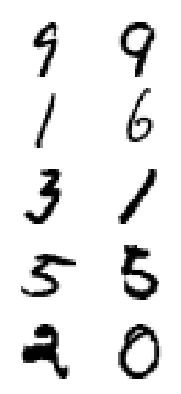

In [169]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [170]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not.

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [0]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large batch_size, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [172]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.6941803
0 Test accuracy: 0.5058
1 Train loss: 0.693889
2 Train loss: 0.6928505
3 Train loss: 0.69512266
4 Train loss: 0.69319344
5 Train loss: 0.6918361
5 Test accuracy: 0.4828
6 Train loss: 0.6942105
7 Train loss: 0.6930231
8 Train loss: 0.6932615
9 Train loss: 0.6919987
10 Train loss: 0.6925525
10 Test accuracy: 0.4907
11 Train loss: 0.6932446
12 Train loss: 0.69175786
13 Train loss: 0.6931235
14 Train loss: 0.6933649
15 Train loss: 0.69492817
15 Test accuracy: 0.4838
16 Train loss: 0.69331056
17 Train loss: 0.69104284
18 Train loss: 0.6837677
19 Train loss: 0.65317655
20 Train loss: 0.61804414
20 Test accuracy: 0.6026
21 Train loss: 0.5915786
22 Train loss: 0.57496065
23 Train loss: 0.5845438
24 Train loss: 0.5680831
25 Train loss: 0.5813681
25 Test accuracy: 0.6655
26 Train loss: 0.505869
27 Train loss: 0.48362994
28 Train loss: 0.41309828
29 Train loss: 0.3648671
30 Train loss: 0.39121088
30 Test accuracy: 0.8493
31 Train loss: 0.37562436
32 Train loss: 0.29328275


Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class.

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the tf.stop_gradient() function. Note that we need one Saver to restore the pretrained DNN A, and another Saver to save the final model:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [174]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9657
10 Test accuracy: 0.9675
20 Test accuracy: 0.9676
30 Test accuracy: 0.9671
40 Test accuracy: 0.9679
50 Test accuracy: 0.9682
60 Test accuracy: 0.9675
70 Test accuracy: 0.9677
80 Test accuracy: 0.9681
90 Test accuracy: 0.9674


Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [0]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [176]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.7771
10 Test accuracy: 0.9296
20 Test accuracy: 0.9351
30 Test accuracy: 0.9298
40 Test accuracy: 0.9425
50 Test accuracy: 0.9427
60 Test accuracy: 0.9427
70 Test accuracy: 0.943
80 Test accuracy: 0.9427
90 Test accuracy: 0.9426
100 Test accuracy: 0.9427
110 Test accuracy: 0.9426
120 Test accuracy: 0.9428
130 Test accuracy: 0.9429
140 Test accuracy: 0.9428
